### Apple Leaf Health Status Using CNNs

Given a photo of an apple leaf, the notebook predicts which of the 4 classes the leaf belongs to. This is a Kaggle competition dataset and  there are no labels for the Test set. So, the training dataset will be split into Train and Validation sets. The challenge is to distinguish between leaves which are <b>healthy</b>, those which are infected with <b>apple rust</b>, those that have <b>apple scab</b>, and those with <b>more than one disease</b>.

Automated monitoring through installation of cameras in the Apple orchards can help focus on the plants which actually needs attention. Farmers can then decide on the treatment with chemicals for resolution.

https://www.kaggle.com/competitions/plant-pathology-2020-fgvc7/data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F

#Torchvision Utilities
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

In [3]:
import shutil
import os
from shutil import copyfile

In [4]:
PATH = 'C:/Users/dhema/Documents/Mannheim/plant-pathology-2020-fgvc7'

In [ ]:
df_csv = pd.read_csv(PATH+'/train.csv')
df_csv.columns

In [57]:
labels = df_csv.columns[1:].tolist()
labels

['healthy', 'multiple_diseases', 'rust', 'scab']

### Class Distribution

- The dataset contains <b>1856</b> samples and each leaf falls under one of the four categories.

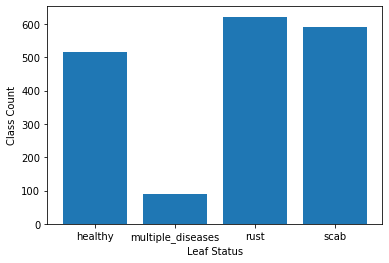

In [64]:
img_count = {}
for cls in labels:
    img_count[cls] = df_csv[cls].sum()
plt.bar(img_count.keys(), img_count.values())
plt.xlabel('Leaf Status')
plt.ylabel('Class Count')
plt.show()
    

### Directory Strucutre Creation

We have all the 4 classes of images in one directory and given a csv file which contains the image_id and the category that image belong to. Hence, it is needed to copy the images into respective class folders.

In [6]:
### Training Directory
os.mkdir('./train')
os.mkdir('./train/healthy')
os.mkdir('./train/multiple_diseases')
os.mkdir('./train/rust')
os.mkdir('./train/scab')

In [7]:
### Validation Directory
os.mkdir('./validation')
os.mkdir('./validation/healthy')
os.mkdir('./validation/multiple_diseases')
os.mkdir('./validation/rust')
os.mkdir('./validation/scab')

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train, valid = train_test_split(df_csv, test_size = 0.2, random_state = 42)
train.head()

,image_id,healthy,multiple_diseases,rust,scab
1455,Train_1455,0,0,1,0
1552,Train_1552,1,0,0,0
300,Train_300,1,0,0,0
1708,Train_1708,0,1,0,0
611,Train_611,0,0,1,0


In [10]:
# Copy the images into their respective directories
src = 'C:/Users/dhema/Documents/Mannheim/FSS2022/AI In Industry/Project Portfolio/Primary/plant-pathology-2020-fgvc7/images'
train_dir = 'C:/Users/dhema/Documents/Mannheim/FSS2022/AI In Industry/Project Portfolio/Primary/train'
valid_dir = 'C:/Users/dhema/Documents/Mannheim/FSS2022/AI In Industry/Project Portfolio/Primary/validation'

In [11]:
# Training Set
for _, row in train.iterrows():
    label =labels[np.argmax(row[1:])]
    #print(row[0], '--',label)
    file = os.path.join(src,row[0]+'.jpg')
    dest = os.path.join(train_dir,label,row[0]+'.jpg')
    copyfile(file,dest)
    
# Validation Set

for _, row in valid.iterrows():
    label =labels[np.argmax(row[1:])]
    #print(row[0], '--',label)
    file = os.path.join(src,row[0]+'.jpg')
    dest = os.path.join(valid_dir,label,row[0]+'.jpg')
    copyfile(file,dest)
    

In [12]:
dataset = ImageFolder(train_dir,transform=ToTensor())

In [13]:
Classes = dataset.classes

In [14]:
img, label = dataset[10]

print('Shape', img.shape)
print('Label', Classes[label])
print('Label No. ', label)

Shape torch.Size([3, 1365, 2048])
Label healthy
Label No.  0


### Sample Images

In [15]:
def show_image(image, label):
    print('Shape : ', image.shape)
    print('Label : ', Classes[label])
    # The image is of shape 3x1365x2048 and plt.imshow expects the color channel to be the last dimension. Permute method helps reshape
    plt.imshow(image.permute(1,2,0))

Shape :  torch.Size([3, 1365, 2048])
Label :  healthy


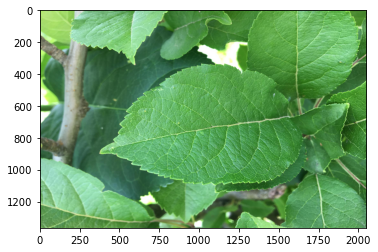

In [16]:
show_image(*dataset[10])

Shape :  torch.Size([3, 1365, 2048])
Label :  scab


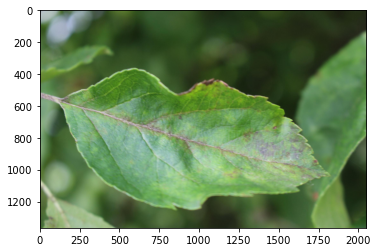

In [17]:
show_image(*dataset[1000])

In [18]:
# set random seed

random_seed = 42
torch.manual_seed(random_seed)

In [19]:
dataset[1000]

(tensor([[[0.2667, 0.2824, 0.3059,  ..., 0.1255, 0.1255, 0.1255],
          [0.2824, 0.2980, 0.3216,  ..., 0.1255, 0.1255, 0.1255],
          [0.3059, 0.3255, 0.3529,  ..., 0.1255, 0.1255, 0.1255],
          ...,
          [0.2784, 0.2784, 0.2745,  ..., 0.2196, 0.2196, 0.2235],
          [0.2745, 0.2745, 0.2745,  ..., 0.2196, 0.2196, 0.2196],
          [0.2745, 0.2745, 0.2706,  ..., 0.2196, 0.2196, 0.2196]],
 
         [[0.3490, 0.3608, 0.3843,  ..., 0.1608, 0.1608, 0.1608],
          [0.3608, 0.3765, 0.4000,  ..., 0.1608, 0.1608, 0.1608],
          [0.3843, 0.4039, 0.4314,  ..., 0.1608, 0.1608, 0.1608],
          ...,
          [0.3922, 0.3922, 0.3922,  ..., 0.3843, 0.3843, 0.3882],
          [0.3882, 0.3882, 0.3922,  ..., 0.3843, 0.3843, 0.3843],
          [0.3882, 0.3882, 0.3882,  ..., 0.3843, 0.3843, 0.3843]],
 
         [[0.3294, 0.3529, 0.3804,  ..., 0.0784, 0.0784, 0.0784],
          [0.3529, 0.3686, 0.3961,  ..., 0.0784, 0.0784, 0.0784],
          [0.3804, 0.4000, 0.4353,  ...,

## Data Augmentation & Normalization

In [20]:
#chanel wise data Normalization

def get_mean_std(dataset):
    # create batches of data
    data_loader = DataLoader(dataset,batch_size = 1)
    
    channel_sum, channel_squared_sum, num_batches = 0, 0, 0
    #loop to process data in batches
    for data,_ in data_loader:
        channel_sum += torch.mean(data, dim = [0,2,3])
        channel_squared_sum += torch.mean(data**2, dim = [0, 2, 3])
        num_batches +=1
  
    # VAR[X] = E[X**2] - E[X]**2
    # STD[X] = sqrt(VAR[X])

    mean = channel_sum/num_batches
    std = (channel_squared_sum/num_batches-mean**2)**0.5
    # transform to numpy array
    mean = mean.numpy()
    std = std.numpy()
    return mean, std


In [21]:
#get_mean_std(dataset)

- Calculating the mean and standard deviation of each channel takes a lot of time. When the batch size was increased it was giving memory/dataset errors. Hence after one successful run the metrics were calculated and kept for future use and the above cell is commented.

array([0.4018925 , 0.5119272 , 0.31237948], dtype=float32),
array([0.20609608, 0.1910669 , 0.18972935], dtype=float32))

In [22]:
# mean, std = get_mean_std(dataset)
# t_mean = tuple(mean)
# t_std = tuple(std)
# stats = (t_mean,t_std)

In [23]:
stat = ((0.4018925 , 0.5119272 , 0.31237948),(0.20609608, 0.1910669 , 0.18972935))

In [24]:
# Transformations for Dataset (Augmentation & Normalization)

train_tfms = tt.Compose([tt.Resize((256,256)),
                         #tt.RandomCrop(224),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stat, inplace=True)])

valid_tfms = tt.Compose([tt.Resize((256,256)),tt.ToTensor(), tt.Normalize(*stat, inplace=True)])

In [25]:
# data is now stored to ImageFolder instances after the above transformations
training_data = ImageFolder(train_dir,train_tfms)
validation_data = ImageFolder(valid_dir,valid_tfms)

In [26]:
batch_size = 64

In [27]:
# data loaders for consuming batches of data
train_dl = DataLoader(training_data, batch_size=batch_size, shuffle=True,num_workers=2, pin_memory=True)
valid_dl = DataLoader(validation_data, batch_size=batch_size,num_workers=2, pin_memory=True)

In [28]:
# Normalized Images
# Print the batch of images

def print_batch(dataloader):
    for batch_images, bacth_labels in dataloader:

        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(batch_images[:30], nrow = 10).permute(1,2,0))
        break


In [29]:
for batch_images, bacth_labels in train_dl:
    print(batch_images.shape)
    break

torch.Size([64, 3, 256, 256])


### Normalized & Transformed Image Vizualizations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


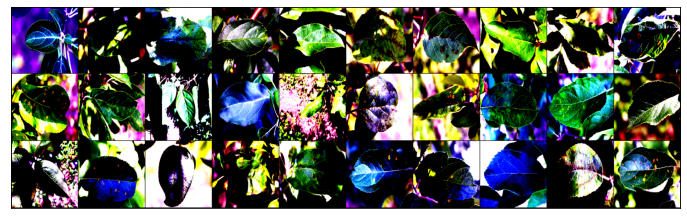

In [30]:
print_batch(train_dl)
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


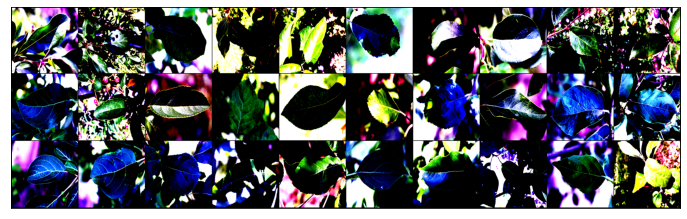

In [31]:
print_batch(valid_dl)

### ImageClassification Base Class

In [32]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch): # calculate training loss
        images, labels = batch
        out = self(images) # Predictions of the model object whihc will be created subsequently in another class.
        loss = F.cross_entropy(out, labels) # calculate loss - using cross entropy loss function
        return loss

    def validation_step(self, batch): # calculate validation loss
        images, labels = batch
        out = self(images)                      #Generate Predictions
        val_loss = F.cross_entropy(out,labels)  # Calculate Loss
        val_accuracy = accuracy_fun(out, labels)    # calculate accuracy
        return {'batch_val_loss': val_loss.detach(), 'batch_val_acc': val_accuracy}

    def validation_epoch_end(self, outputs): # Calculate loss at the end of epoch
        batch_loss =  [X['batch_val_loss'] for X in outputs] # get the batch of validation losses
        epoch_loss =  torch.stack(batch_loss).mean() # calculate mean of the all batch losses to get epcoh loss
        batch_acc = [X['batch_val_acc'] for X in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'epoch_val_loss':epoch_loss,'epoch_val_acc':epoch_acc}

    def epoch_end(self, epoch, result):
        print('Epoch[{}], Train Loss:{:.2f}, Val Loss:{:.2f}, Val Acc:{:.2f}'.format(epoch,result['epoch_train_loss'], result['epoch_val_loss'], result['epoch_val_acc']))

def accuracy_fun(outputs,labels):
    _, preds = torch.max(outputs, dim =1)
    return torch.sum(preds==labels)/len(preds)

### Custom extension Class

In [33]:
class AppleLeafHealth(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 128 x 128
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 64 x 64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 32 x 32
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 8 x 8
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 2 x 2
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 1024 x 1 x 1
            
            nn.Flatten(), 
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 4))
        
    def forward(self, xb):
        return self.network(xb)
    

In [34]:
model = AppleLeafHealth()
model

AppleLeafHealth(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [35]:
for images, labels in train_dl:
    print('images shape',images.shape)
    out = model(images)
    print('out shape', out.shape)
    
    break

images shape torch.Size([64, 3, 256, 256])
out shape torch.Size([64, 4])


### Device Selection(CPU/GPU)

The below part was used to run the notebook on Google Colab.

In [36]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [37]:
device = get_default_device()
device

device(type='cpu')

### Model Training

In [38]:
@torch.no_grad()
# evaluate
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
#fit
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['epoch_train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [39]:
epochs = 10
opt_funct = torch.optim.Adam
lr =0.001

In [40]:
evaluate(model, valid_dl)

{'epoch_val_loss': tensor(1.4324), 'epoch_val_acc': tensor(0.0469)}

In [41]:
%%time
import time
start_time = time.time()
history = fit(epochs,lr,model,train_dl,valid_dl,opt_funct)
end_time = time.time()

Epoch[0], Train Loss:1.34, Val Loss:1.23, Val Acc:0.31
Epoch[1], Train Loss:1.25, Val Loss:1.23, Val Acc:0.33
Epoch[2], Train Loss:1.26, Val Loss:1.24, Val Acc:0.26
Epoch[3], Train Loss:1.25, Val Loss:1.23, Val Acc:0.31
Epoch[4], Train Loss:1.24, Val Loss:1.23, Val Acc:0.31
Epoch[5], Train Loss:1.24, Val Loss:1.23, Val Acc:0.31
Epoch[6], Train Loss:1.24, Val Loss:1.23, Val Acc:0.31
Epoch[7], Train Loss:1.24, Val Loss:1.23, Val Acc:0.39
Epoch[8], Train Loss:1.25, Val Loss:1.23, Val Acc:0.32
Epoch[9], Train Loss:1.26, Val Loss:1.23, Val Acc:0.31
Wall time: 26min 11s


### Saving the Model

The model with just 10 epochs took 30 min to train. We can improve the training time by using better computing power, transfer learning techniques.

In [42]:
#torch.save(model.state_dict(), 'AppleLeafHealth-cnn.pth')

### Model Losses & Accuracy Vizualization

#### Validation Accuracy


In [50]:
def plot_accuracies(history):
    accuracies = [x['epoch_val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

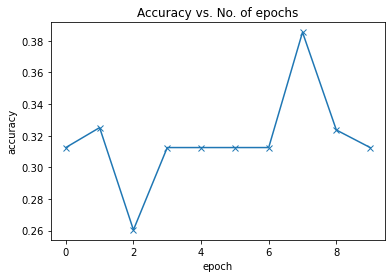

In [51]:
plot_accuracies(history)

#### Training & Validation Losses

The validation loss decreases until epoch 7 but then increases afterwards.

In [45]:
def plot_losses(history):
    train_losses = [x.get('epoch_train_loss') for x in history]
    val_losses = [x['epoch_val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

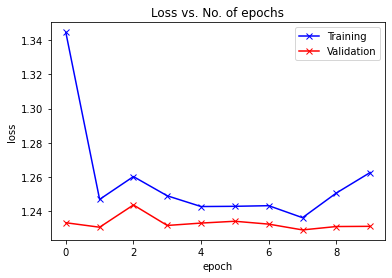

In [46]:
plot_losses(history)

In [47]:
#model2 = to_device(AppleLeafHealth(), device)

In [48]:
#model2.load_state_dict(torch.load('AppleLeafHealth-cnn.pth'))

In [ ]:
#epochs2 = 10
#opt_funct = torch.optim.Adam
#lr2 =0.01

In [ ]:
%%time
import time
start_time = time.time()
#history = fit(epochs2,lr2,model2,train_dl,valid_dl,opt_funct)
end_time = time.time()

### Prediction

In [69]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return training_data.classes[preds[0].item()]

Label: healthy , Predicted: rust


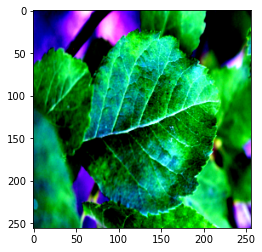

In [77]:
img, lab = validation_data[33]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', training_data.classes[lab], ', Predicted:', predict_image(img, model))


Label: rust , Predicted: rust


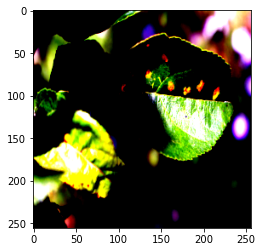

In [75]:
img, lab = validation_data[120]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', training_data.classes[lab], ', Predicted:', predict_image(img, model))

### Summary & Discussion

Training deep convolutional neural networks with high quality images and complex networks is resource and time intensive. I have done the below to improve the performance and reduce the training time.

<b>Data Normalization</b> The appleaf images are mostly dominated by green color and the pixel values from this channel can disproportionately impact the losses and gradients. This was overcome by subtracting the mean and dividing from the pixel values before dividing them with respective channel standard deviations.

<b>Data Augmentation</b> Due to small dataset size, random transformations were applied whihc helps the network in better training.

<b>Adam Optimizer</b> Instead of SGD, I have used adam optimizer whihc is state of the art whihc uses adaptive learning rate and helps in faster trainning.



### Further Improvements

The below techniques can further be applied along with running the model on a GPU will certainly improve the run time.

Using <b>Transfer learning</b> for faster training and check whether complex networks can really improve the accuracy with the dataset at hand. Also, the apple leaf dataset is small for a CNN project and it can be the reason for the poor performance. Adding <b>Residual connects</b> and <b> Batch Normalization </b> could potentially improve the performacnce of the model.